In [1]:
from scipy.signal import find_peaks
from scipy.signal import lfilter
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import cv2
import os

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print(os.listdir())

['main.py', 'puCounting.ipynb', 'puCountingSoftware.py', 'RemoveBackgroundVer9.h5', 'testData']


In [4]:
ds_detector = tf.keras.models.load_model('RemoveBackgroundVer9.h5')
clip_folder_path = "testData/side/clip/"

In [5]:
clip_name = (sorted(os.listdir(clip_folder_path)))[1]
image_x = 256 #h
image_y = 144 #w
lastHeightDurian = 0
heightDurian = 0
radiusDurian = []
rawImg = []
ansImg = []
removeBgImg = []
remove_bg_runtime = 0
img_process_time = 0
preprocess_runtime = 0
count_runtime = 0
i = 0

clip = cv2.VideoCapture(clip_folder_path+clip_name)
ret, frame = clip.read()
start_time = time.time()

while(clip.isOpened()):

  startTime = time.time()
  ret, frame = clip.read()
  if ret == False:
    runTime = time.time() - start_time
    break
  i += 1
  img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  rawImg.append(frame)
  height, width, _ = img.shape
  if height != image_x:
    if(height > width):
      tmp = int((height - width) / 2)
      img = img[tmp:tmp + width, :]
    small = cv2.resize(img, (image_x,image_y))
  small = small/255
  k = ds_detector.predict(np.array([small]))

  remove_bg_runtime += (time.time()) - startTime
  startTime = time.time()
  
  removeBg_img = (k.reshape(image_y,image_x))*255
  ansImg.append(removeBg_img)

  img_process_time += time.time() - startTime
  startTime = time.time()

  filter = np.full((144, 256), 150)
  filtered = removeBg_img - filter
  filtered[filtered<0] = 0
  filtered[filtered>0] = 255
  maxL = 0
  maxR = 143
  count = 0
  removeBgImg.append(filtered)

  preprocess_runtime += time.time() - startTime
  startTime = time.time()

  while(True):
    if count >3:
        maxL -= 5
        break
    elif ((list(filtered[maxL]).count(255) != 0)):
      count += 1
    maxL += 1
  count = 0
  while(True):
    if count > 3:
        maxR += 5
        break
    elif ((list(filtered[maxR]).count(255) != 0)):
      count += 1
    maxR -= 1
  radiusDurian.append(maxR - maxL)
  count_runtime += time.time() - startTime

AllRuntime : 0 m 14.02347445487976 sec.
RemoveBG Runtime : 0 m 13.273524522781372 sec.
IMG Process Runtime : 0 m 0.005982875823974609 sec.
Preprocess Runtime : 0 m 0.04189705848693848 sec.
Count Runtime : 0 m 0.7010719776153564 sec.
raw_data


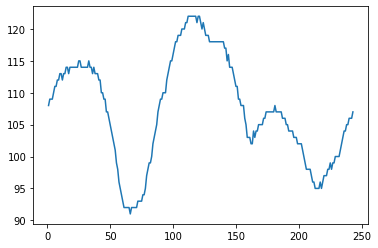

Count : 17
Count : 9
Count : 2
Count : 11


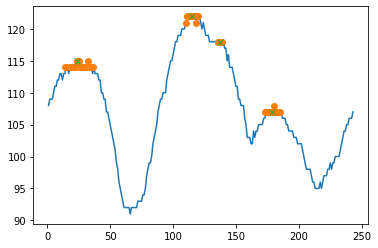

Ans : 4
Test : 47
[14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 136, 137, 138, 139, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185]


In [ ]:
print("AllRuntime : " + str(int((runTime/60)-((runTime/60)%1))) + ' m ' + str(runTime%60) + ' sec.')
print("RemoveBG Runtime : " + str(int((remove_bg_runtime/60)-((remove_bg_runtime/60)%1))) + ' m ' + str(remove_bg_runtime%60) + ' sec.')
print("IMG Process Runtime : " + str(int((img_process_time/60)-((img_process_time/60)%1))) + ' m ' + str(img_process_time%60) + ' sec.')
print("Preprocess Runtime : " + str(int((preprocess_runtime/60)-((preprocess_runtime/60)%1))) + ' m ' + str(preprocess_runtime%60) + ' sec.')
print("Count Runtime : " + str(int((count_runtime/60)-((count_runtime/60)%1))) + ' m ' + str(count_runtime%60) + ' sec.')
y_axis = radiusDurian
x_axis = list(range(1,len(radiusDurian)+1))
print('raw_data')
plt.plot(x_axis, y_axis)
plt.show()
n = 1
b = [1.0 / n] * n
a = 1
reNoise = lfilter(b,a,y_axis)

test = []
ans = []
count = 0
stock = 0
check = 0

for i in range(8, len(reNoise)-8, 1):
  count += 1
  condition = (((reNoise[i] - reNoise[i-8])/8 >= 0) and ((reNoise[i] - reNoise[i+8])/8 >= 0))
  # print(condition)
  if (condition and (count >= 1)):
    count = 0
    test.append(i)

count = 0;

for i in (range(1,len(test)-1,1)):
  if ((test[i] - test[i-1] < 8) and (test[i+1] - test[i] < 8)):
    stock += test[i]
    count += 1
  elif (stock > 0 and count > 1):
    check = 0
    print('Count : ' + str(count))
    ans.append(int(stock/count))
    count = 0
    stock = 0
if (stock > 2 and count > 2 and (i == len(test)-2)):
  print('Count : ' + str(count))
  ans.append(int(stock/count))
elif ((((reNoise[0] - reNoise[8])/8 >= 0) and ((reNoise[-1] - reNoise[-8])/8 >= 0))):
  if ans[0] - (int((test[0]+(len(reNoise) - test[-1]))/2)) > 10:
    ans.append(int((test[0]+(len(reNoise) - test[-1]))/2))

plt.plot(x_axis, reNoise)
plt.plot(test, reNoise[test], "o")
plt.plot(ans, reNoise[ans], "x")
plt.show()
print('Ans : ' + str(len(ans)))
print('Test : ' + str(len(test)))
print(test)